In [3]:
import cv2
import numpy as np
import requests
from PIL import Image
import io

jetbot_ip = '194.47.156.221'  # Ändra till din IP

# Parametrar
KNOWN_WIDTH = 7.15  # iPhone bredd i cm
FOCAL_LENGTH = 1000  # Byt till kalibrerat värde!

def get_jetbot_frame(jetbot_ip):
    response = requests.get(f'http://{jetbot_ip}:8080/camera')
    image = Image.open(io.BytesIO(response.content))
    frame = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    return frame

while True:
    try:
        frame = get_jetbot_frame(jetbot_ip)

        # LAB konvertering
        lab = cv2.cvtColor(frame, cv2.COLOR_BGR2LAB)
        L, A, B = cv2.split(lab)
        _, mask = cv2.threshold(A, 150, 255, cv2.THRESH_BINARY)

        kernel = np.ones((5,5), np.uint8)
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
        mask = cv2.morphologyEx(mask, cv2.MORPH_DILATE, kernel)

        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        for contour in contours:
            area = cv2.contourArea(contour)
            if area > 500:
                x, y, w, h = cv2.boundingRect(contour)
                cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 3)

                # Avståndsberäkning
                distance_cm = (KNOWN_WIDTH * FOCAL_LENGTH) / w
                cv2.putText(frame, f"Distance: {distance_cm:.2f} cm", (x, y - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2)

        # Visa
        cv2.imshow("Jetbot Red Object + Distance", frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    except Exception as e:
        print(f"Error: {e}")

cv2.destroyAllWindows()


KeyboardInterrupt: 

### DISTANCE AND ANDLE EXPERIMENTATION

#### Yellow square 

In [8]:
import cv2
import numpy as np
from IPython.display import display, clear_output
import requests
from PIL import Image as PILImage
import io
import time

# Define yellow color range in HSV
lower_yellow = np.array([20, 100, 100])
upper_yellow = np.array([30, 255, 255])

def detect_yellow_vector(image):
    """
    Detect the yellow square and calculate the vector from the image center.
    """
    # Convert to OpenCV format
    image_np = np.array(image)

    # Convert to HSV color space
    hsv = cv2.cvtColor(image_np, cv2.COLOR_RGB2HSV)

    # Create a mask for yellow color
    mask = cv2.inRange(hsv, lower_yellow, upper_yellow)

    # Find contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) > 0:
        # Find the largest contour
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)

        # Calculate the center of the yellow object
        center_x, center_y = x + w // 2, y + h // 2

        # Image center
        image_center = (image_np.shape[1] // 2, image_np.shape[0] // 2)

        # Vector from image center to yellow object
        vector = (center_x - image_center[0], center_y - image_center[1])

        # Draw rectangle and vector
        cv2.rectangle(image_np, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.arrowedLine(image_np, image_center, (center_x, center_y), (0, 255, 0), 2)

        return image_np, vector
    
    # If no yellow is found, return the original image and None
    return image_np, None


# Continuous analysis loop
def continuous_analysis(jetbot_ip):
    """
    Continuously fetches images from the Jetbot and analyzes for yellow detection.
    """
    try:
        while True:
            response = requests.get(f'http://{jetbot_ip}:8080/camera')
            image = PILImage.open(io.BytesIO(response.content))

            # Analyze the image
            analyzed_image, vector = detect_yellow_vector(image)

            # Display the image with the vector
            clear_output(wait=True)
            display(PILImage.fromarray(analyzed_image))

            # Print the vector if found
            if vector:
                print(f"Vector to yellow object: {vector}")
            else:
                print("Yellow object not found")

            # Control the frame rate
            time.sleep(0.1)

    except KeyboardInterrupt:
        print("Continuous analysis stopped.")


# Run the continuous analysis
continuous_analysis(jetbot_ip)


Continuous analysis stopped.


### First worked but really badly!

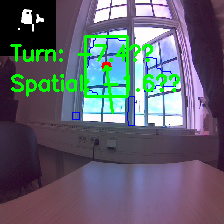

Blue square detected:
  • Center: (106, 66)
  • Turning angle: -7.43°
  • Spatial angle: -1.61°
  • Relative distance (pixels): 46.39
  • Area: 2109.5 pixels²
  • Dimensions: 42x60 pixels
Continuous analysis stopped.


In [21]:
import cv2
import numpy as np
from IPython.display import display, clear_output
import requests
from PIL import Image as PILImage
import io
import time
import math

# Define blue color range in HSV, adjusted for the specific blue in your image
# The blue in your image appears to be more of a cyan/sky blue
lower_blue = np.array([90, 50, 50])   # Adjusted for a wider range of blues
upper_blue = np.array([110, 255, 255])

def detect_colored_square(image, color_name="blue"):
    """
    Enhanced detection of colored squares with improved angle and distance calculations.
    Color can be specified (default is blue based on the image provided).
    """
    # Convert to OpenCV format
    image_np = np.array(image)
    original_image = image_np.copy()
    
    # Get image dimensions
    height, width = image_np.shape[:2]
    image_center = (width // 2, height // 2)
    
    # Convert to HSV color space
    hsv = cv2.cvtColor(image_np, cv2.COLOR_RGB2HSV)
    
    # Determine color ranges based on specified color
    if color_name.lower() == "blue":
        lower_color = lower_blue
        upper_color = upper_blue
    else:  # Default fallback to blue
        lower_color = lower_blue
        upper_color = upper_blue
    
    # Create a mask for the specified color
    mask = cv2.inRange(hsv, lower_color, upper_color)
    
    # Apply morphological operations to reduce noise - larger kernel for better results
    kernel = np.ones((7, 7), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    # Find contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Debug: Draw all contours in red for visualization
    cv2.drawContours(image_np, contours, -1, (0, 0, 255), 1)
    
    # Debug: Add mask as small overlay in corner for visualization
    mask_small = cv2.resize(mask, (width // 4, height // 4))
    mask_small_colored = cv2.cvtColor(mask_small, cv2.COLOR_GRAY2BGR)
    image_np[0:height//4, 0:width//4] = mask_small_colored
    
    if len(contours) > 0:
        # Find the largest contour as a simple approach
        largest_contour = max(contours, key=cv2.contourArea)
        area = cv2.contourArea(largest_contour)
        
        # Skip if the area is too small
        if area < 1000:  # Adjusted threshold based on your image
            cv2.putText(image_np, f"Contours found but too small: {len(contours)}", 
                       (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
            return image_np, None
        
        # Get the bounding rectangle
        x, y, w, h = cv2.boundingRect(largest_contour)
        
        # Calculate center
        center_x = x + w // 2
        center_y = y + h // 2
        
        # Draw the rectangle and center
        cv2.rectangle(image_np, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.circle(image_np, (center_x, center_y), 5, (255, 0, 0), -1)
        
        # Draw vector from image center to object center
        cv2.arrowedLine(image_np, image_center, (center_x, center_y), (0, 255, 0), 2)
        
        # Calculate distance (in pixels)
        pixel_distance = math.sqrt((center_x - image_center[0])**2 + (center_y - image_center[1])**2)
        
        # Calculate horizontal angle (turning angle)
        # Positive angle means turn right, negative means turn left
        horizontal_angle = math.degrees(math.atan2(center_x - image_center[0], image_center[1] - center_y))
        
        # Calculate spatial angle (position in 3D space)
        # This is a simplified estimation assuming a fixed field of view
        fov_horizontal = 60  # Approximate field of view in degrees
        spatial_angle = (center_x - image_center[0]) / (width / 2) * (fov_horizontal / 2)
        
        # Calculate approximate relative size (for distance estimation)
        relative_size = area / (width * height)
        
        # Add detection info to image
        cv2.putText(image_np, f"Turn: {horizontal_angle:.1f}°", (10, 60), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        cv2.putText(image_np, f"Spatial: {spatial_angle:.1f}°", (10, 90), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        
        return image_np, {
            'center': (center_x, center_y),
            'pixel_distance': pixel_distance,
            'horizontal_angle': horizontal_angle,
            'spatial_angle': spatial_angle,
            'relative_size': relative_size,
            'area': area,
            'width': w,
            'height': h
        }
    
    # Add debug info to the image
    cv2.putText(image_np, f"Contours found: {len(contours)}", (10, 30), 
               cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
    
    # If no blue square is found
    return image_np, None

def continuous_analysis(jetbot_ip):
    """
    Continuously fetches images from the Jetbot and analyzes for blue square detection
    with improved angle and distance calculations.
    """
    try:
        while True:
            try:
                response = requests.get(f'http://{jetbot_ip}:8080/camera')
                image = PILImage.open(io.BytesIO(response.content))
                
                # Analyze the image
                analyzed_image, detection_data = detect_colored_square(image, "blue")
                
                # Display the image with the detection
                clear_output(wait=True)
                display(PILImage.fromarray(analyzed_image))
                
                # Print the detection data if found
                if detection_data:
                    print(f"Blue square detected:")
                    print(f"  • Center: {detection_data['center']}")
                    print(f"  • Turning angle: {detection_data['horizontal_angle']:.2f}°")
                    print(f"  • Spatial angle: {detection_data['spatial_angle']:.2f}°")
                    print(f"  • Relative distance (pixels): {detection_data['pixel_distance']:.2f}")
                    print(f"  • Area: {detection_data['area']:.1f} pixels²")
                    print(f"  • Dimensions: {detection_data['width']}x{detection_data['height']} pixels")
                else:
                    print("Blue square not detected")
                
            except Exception as e:
                print(f"Error in processing: {e}")
                
            # Control the frame rate
            time.sleep(0.1)
    
    except KeyboardInterrupt:
        print("Continuous analysis stopped.")

# Function to help debug color detection with interactive HSV tuning
def debug_color_detection(image, h_min=90, h_max=130, s_min=50, s_max=255, v_min=50, v_max=255):
    """
    Function to debug color detection with visualization of HSV thresholds
    """
    # Convert to OpenCV format
    image_np = np.array(image)
    
    # Convert to HSV color space
    hsv = cv2.cvtColor(image_np, cv2.COLOR_RGB2HSV)
    
    # Create a mask using the provided HSV values
    lower = np.array([h_min, s_min, v_min])
    upper = np.array([h_max, s_max, v_max])
    
    mask = cv2.inRange(hsv, lower, upper)
    
    # Apply morphological operations
    kernel = np.ones((7, 7), np.uint8)
    processed_mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    processed_mask = cv2.morphologyEx(processed_mask, cv2.MORPH_CLOSE, kernel)
    
    # Find contours in both the original and processed masks
    contours_orig, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours_proc, _ = cv2.findContours(processed_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Create visualizations
    result_orig = image_np.copy()
    result_proc = image_np.copy()
    
    # Draw contours and info
    cv2.drawContours(result_orig, contours_orig, -1, (0, 0, 255), 2)
    cv2.drawContours(result_proc, contours_proc, -1, (0, 255, 0), 2)
    
    # Add a small version of the mask as an overlay in the corner of each image
    h, w = mask.shape
    mask_small = cv2.resize(mask, (w // 4, h // 4))
    proc_mask_small = cv2.resize(processed_mask, (w // 4, h // 4))
    
    # Convert to BGR for overlay
    mask_small_bgr = cv2.cvtColor(mask_small, cv2.COLOR_GRAY2BGR)
    proc_mask_small_bgr = cv2.cvtColor(proc_mask_small, cv2.COLOR_GRAY2BGR)
    
    # Add overlays
    result_orig[0:h//4, 0:w//4] = mask_small_bgr
    result_proc[0:h//4, 0:w//4] = proc_mask_small_bgr
    
    # Add text with HSV ranges and contour counts
    cv2.putText(result_orig, f"HSV: H({h_min}-{h_max}) S({s_min}-{s_max}) V({v_min}-{v_max})", 
               (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
    cv2.putText(result_orig, f"Original mask: {len(contours_orig)} contours", 
               (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
    
    cv2.putText(result_proc, f"HSV: H({h_min}-{h_max}) S({s_min}-{s_max}) V({v_min}-{v_max})", 
               (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
    cv2.putText(result_proc, f"Processed mask: {len(contours_proc)} contours", 
               (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
    
    # If we have contours, draw the largest one differently
    if len(contours_proc) > 0:
        largest = max(contours_proc, key=cv2.contourArea)
        area = cv2.contourArea(largest)
        x, y, w, h = cv2.boundingRect(largest)
        
        cv2.rectangle(result_proc, (x, y), (x + w, y + h), (255, 255, 0), 2)
        cv2.putText(result_proc, f"Area: {area:.0f} px²", 
                   (10, 90), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2)
    
    return {
        'original': result_orig,
        'processed': result_proc,
        'mask': mask,
        'processed_mask': processed_mask
    }

# Function to test on a static image
def analyze_static_image(image_path):
    """Analyze a static image file"""
    image = PILImage.open(image_path)
    analyzed_image, detection_data = detect_colored_square(image, "blue")
    
    display(PILImage.fromarray(analyzed_image))
    
    if detection_data:
        print(f"Blue square detected:")
        print(f"  • Center: {detection_data['center']}")
        print(f"  • Turning angle: {detection_data['horizontal_angle']:.2f}°")
        print(f"  • Spatial angle: {detection_data['spatial_angle']:.2f}°")
        print(f"  • Relative distance (pixels): {detection_data['pixel_distance']:.2f}")
        print(f"  • Area: {detection_data['area']:.1f} pixels²")
        print(f"  • Dimensions: {detection_data['width']}x{detection_data['height']} pixels")
    else:
        print("Blue square not detected")
    
    return analyzed_image, detection_data

# Function to interactively find the best HSV values for your specific blue
def find_best_hsv(image):
    """
    Test various HSV ranges to find the one that best detects your blue object
    """
    # Test different blue ranges
    ranges = [
        # Sky blue / cyan ranges
        {"name": "Light Blue", "h_min": 90, "h_max": 110, "s_min": 50, "s_max": 255, "v_min": 50, "v_max": 255},
        {"name": "Medium Blue", "h_min": 100, "h_max": 130, "s_min": 50, "s_max": 255, "v_min": 50, "v_max": 255},
        {"name": "Darker Blue", "h_min": 110, "h_max": 130, "s_min": 100, "s_max": 255, "v_min": 100, "v_max": 255},
        
        # More relaxed ranges for poor lighting
        {"name": "Relaxed Blue", "h_min": 90, "h_max": 140, "s_min": 40, "s_max": 255, "v_min": 40, "v_max": 255},
        
        # Try some other blue-like colors in case of color distortion
        {"name": "Cyan", "h_min": 80, "h_max": 100, "s_min": 50, "s_max": 255, "v_min": 50, "v_max": 255},
        {"name": "Blue-Green", "h_min": 85, "h_max": 110, "s_min": 40, "s_max": 255, "v_min": 40, "v_max": 255},
    ]
    
    results = []
    for r in ranges:
        debug = debug_color_detection(
            image, 
            r["h_min"], r["h_max"], 
            r["s_min"], r["s_max"], 
            r["v_min"], r["v_max"]
        )
        
        # Count white pixels in the processed mask to measure detection quality
        white_pixels = cv2.countNonZero(debug["processed_mask"])
        
        # Find contours to check if we have suitable candidates
        contours, _ = cv2.findContours(debug["processed_mask"], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        largest_area = 0
        if contours:
            largest_area = cv2.contourArea(max(contours, key=cv2.contourArea))
        
        print(f"Testing {r['name']}:")
        print(f"  • HSV Range: H({r['h_min']}-{r['h_max']}) S({r['s_min']}-{r['s_max']}) V({r['v_min']}-{r['v_max']})")
        print(f"  • White pixels: {white_pixels}")
        print(f"  • Contours found: {len(contours)}")
        print(f"  • Largest area: {largest_area:.1f} pixels²")
        print()
        
        # Display the processed result
        display(PILImage.fromarray(debug["processed"]))
        
        results.append({
            "name": r["name"],
            "hsv": (r["h_min"], r["h_max"], r["s_min"], r["s_max"], r["v_min"], r["v_max"]),
            "white_pixels": white_pixels,
            "contours": len(contours),
            "largest_area": largest_area
        })
    
    # Find the best candidate (has contours and largest area)
    valid_results = [r for r in results if r["contours"] > 0 and r["largest_area"] > 1000]
    
    if valid_results:
        best = max(valid_results, key=lambda x: x["largest_area"])
        print(f"Recommended HSV range: {best['name']}")
        print(f"H({best['hsv'][0]}-{best['hsv'][1]}) S({best['hsv'][2]}-{best['hsv'][3]}) V({best['hsv'][4]}-{best['hsv'][5]})")
        
        # Update the global variables with the best range
        global lower_blue, upper_blue
        lower_blue = np.array([best['hsv'][0], best['hsv'][2], best['hsv'][4]])
        upper_blue = np.array([best['hsv'][1], best['hsv'][3], best['hsv'][5]])
        
        return best["hsv"]
    else:
        print("No good HSV range found. Try custom ranges.")
        return None

# Example usage:
# If you have the image path:
# img = PILImage.open('your_image.jpg')
# best_hsv = find_best_hsv(img)  # This will print and display results
# 
# Then run the continuous analysis:
continuous_analysis(jetbot_ip)  # This will use the updated HSV ranges

### Experiment number 3
#### Above was working quite well for the blue square using image analysis on ChatGPT

### YOLO V8

In [18]:
!pip install ultralytics

   ---------------------------------------- 1.0/1.0 MB 9.7 MB/s eta 0:00:00


    opencv-python (>=3.) ; extra == 'all'
                  ~~~~^
ERROR: Exception:
Traceback (most recent call last):
  File "c:\anaconda3\lib\site-packages\pip\_internal\cli\base_command.py", line 106, in _run_wrapper
    status = _inner_run()
  File "c:\anaconda3\lib\site-packages\pip\_internal\cli\base_command.py", line 97, in _inner_run
    return self.run(options, args)
  File "c:\anaconda3\lib\site-packages\pip\_internal\cli\req_command.py", line 67, in wrapper
    return func(self, options, args)
  File "c:\anaconda3\lib\site-packages\pip\_internal\commands\install.py", line 484, in run
    installed_versions[distribution.canonical_name] = distribution.version
  File "c:\anaconda3\lib\site-packages\pip\_internal\metadata\pkg_resources.py", line 192, in version
    return parse_version(self._dist.version)
  File "c:\anaconda3\lib\site-packages\pip\_vendor\packaging\version.py", line 56, in parse
    return Version(version)
  File "c:\anaconda3\lib\site-packages\pip\_vendor\packa

In [19]:
import cv2
import requests
from ultralytics import YOLO
from IPython.display import display, clear_output
import numpy as np
import time
from PIL import Image as PILImage
import io

# Load the pre-trained model
model = YOLO('yolov8n.pt')  # Use 'yolov8s.pt' or 'yolov8m.pt' for higher accuracy

# Your Jetbot IP address
#jetbot_ip = '194.47.156.22'  # Change this to your actual Jetbot IP address

def detect_and_display(jetbot_ip):
    """
    Continuously fetches images from the Jetbot camera, runs YOLOv8 detection,
    and displays the results in real-time.
    """
    try:
        while True:
            # Get the image from the Jetbot camera
            response = requests.get(f'http://{jetbot_ip}:8080/camera')
            image = PILImage.open(io.BytesIO(response.content))
            frame = np.array(image)

            # YOLOv8 Inference
            results = model(frame)

            # Parse results and draw bounding boxes
            for result in results:
                for box in result.boxes:
                    x1, y1, x2, y2 = map(int, box.xyxy[0])
                    confidence = box.conf[0]
                    label = model.names[int(box.cls[0])]

                    # Draw bounding box and label
                    cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                    cv2.putText(frame, f"{label} {confidence:.2f}", (x1, y1 - 10),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

            # Display the result
            clear_output(wait=True)
            display(PILImage.fromarray(frame))
            
            # Limit frame rate
            time.sleep(0.1)

    except KeyboardInterrupt:
        print("Detection loop stopped.")

# Start detection
detect_and_display(jetbot_ip)


Creating new Ultralytics Settings v0.0.6 file  
View Ultralytics Settings with 'yolo settings' or at 'C:\Users\fredr\AppData\Roaming\Ultralytics\settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


  0%|          | 0.00/6.25M [00:00<?, ?B/s]

NotImplementedError: Could not run 'torchvision::nms' with arguments from the 'CUDA' backend. This could be because the operator doesn't exist for this backend, or was omitted during the selective/custom build process (if using custom build). If you are a Facebook employee using PyTorch on mobile, please visit https://fburl.com/ptmfixes for possible resolutions. 'torchvision::nms' is only available for these backends: [CPU, QuantizedCPU, BackendSelect, Python, FuncTorchDynamicLayerBackMode, Functionalize, Named, Conjugate, Negative, ZeroTensor, ADInplaceOrView, AutogradOther, AutogradCPU, AutogradCUDA, AutogradXLA, AutogradMPS, AutogradXPU, AutogradHPU, AutogradLazy, Tracer, AutocastCPU, AutocastCUDA, FuncTorchBatched, FuncTorchVmapMode, Batched, VmapMode, FuncTorchGradWrapper, PythonTLSSnapshot, FuncTorchDynamicLayerFrontMode, PythonDispatcher].

CPU: registered at C:\tools\MINICO~1\CONDA-~2\TORCHV~1\work\torchvision\csrc\ops\cpu\nms_kernel.cpp:112 [kernel]
QuantizedCPU: registered at C:\tools\MINICO~1\CONDA-~2\TORCHV~1\work\torchvision\csrc\ops\quantized\cpu\qnms_kernel.cpp:124 [kernel]
BackendSelect: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\BackendSelectFallbackKernel.cpp:3 [backend fallback]
Python: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\PythonFallbackKernel.cpp:140 [backend fallback]
FuncTorchDynamicLayerBackMode: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\functorch\DynamicLayer.cpp:488 [backend fallback]
Functionalize: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\FunctionalizeFallbackKernel.cpp:291 [backend fallback]
Named: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\NamedRegistrations.cpp:7 [backend fallback]
Conjugate: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\ConjugateFallback.cpp:18 [backend fallback]
Negative: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\NegateFallback.cpp:18 [backend fallback]
ZeroTensor: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\ZeroTensorFallback.cpp:86 [backend fallback]
ADInplaceOrView: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:64 [backend fallback]
AutogradOther: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:35 [backend fallback]
AutogradCPU: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:39 [backend fallback]
AutogradCUDA: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:47 [backend fallback]
AutogradXLA: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:51 [backend fallback]
AutogradMPS: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:59 [backend fallback]
AutogradXPU: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:43 [backend fallback]
AutogradHPU: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:68 [backend fallback]
AutogradLazy: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:55 [backend fallback]
Tracer: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\autograd\TraceTypeManual.cpp:296 [backend fallback]
AutocastCPU: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\autocast_mode.cpp:482 [backend fallback]
AutocastCUDA: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\autocast_mode.cpp:324 [backend fallback]
FuncTorchBatched: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\functorch\LegacyBatchingRegistrations.cpp:743 [backend fallback]
FuncTorchVmapMode: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\functorch\VmapModeRegistrations.cpp:28 [backend fallback]
Batched: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\BatchingRegistrations.cpp:1064 [backend fallback]
VmapMode: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\VmapModeRegistrations.cpp:33 [backend fallback]
FuncTorchGradWrapper: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\functorch\TensorWrapper.cpp:189 [backend fallback]
PythonTLSSnapshot: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\PythonFallbackKernel.cpp:148 [backend fallback]
FuncTorchDynamicLayerFrontMode: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\functorch\DynamicLayer.cpp:484 [backend fallback]
PythonDispatcher: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\PythonFallbackKernel.cpp:144 [backend fallback]


In [20]:
import cv2
import requests
from ultralytics import YOLO
from IPython.display import display, clear_output
import numpy as np
import time
from PIL import Image as PILImage
import io

# Load the pre-trained model
model = YOLO('yolov8n.pt')  # Use 'yolov8s.pt' or 'yolov8m.pt' for higher accuracy

# Your Jetbot IP address
#jetbot_ip = '194.47.156.22'  # Change this to your actual Jetbot IP address

# Video save parameters
output_filename = "jetbot_detection.mp4"
fps = 10
duration = 60  # in seconds
frame_size = (224, 224)  # Resolution of your camera feed
fourcc = cv2.VideoWriter_fourcc(*'mp4v')

# Initialize VideoWriter
video_writer = cv2.VideoWriter(output_filename, fourcc, fps, frame_size)

def detect_and_record(jetbot_ip):
    """
    Continuously fetches images from the Jetbot camera, runs YOLOv8 detection,
    displays the results in real-time, and saves it as a video file.
    """
    start_time = time.time()
    print(f"Recording started... Saving to {output_filename}")

    try:
        while True:
            # Stop after 1 minute
            if time.time() - start_time > duration:
                print("Recording finished.")
                break
            
            # Get the image from the Jetbot camera
            response = requests.get(f'http://{jetbot_ip}:8080/camera')
            image = PILImage.open(io.BytesIO(response.content))
            frame = np.array(image)

            # YOLOv8 Inference
            results = model(frame)

            # Parse results and draw bounding boxes
            for result in results:
                for box in result.boxes:
                    x1, y1, x2, y2 = map(int, box.xyxy[0])
                    confidence = box.conf[0]
                    label = model.names[int(box.cls[0])]

                    # Draw bounding box and label
                    cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                    cv2.putText(frame, f"{label} {confidence:.2f}", (x1, y1 - 10),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

            # Resize to match the VideoWriter resolution
            resized_frame = cv2.resize(frame, frame_size)
            
            # Write the frame to the video file
            video_writer.write(resized_frame)

            # Display the result
            clear_output(wait=True)
            display(PILImage.fromarray(frame))
            
            # Limit frame rate
            time.sleep(1 / fps)

    except KeyboardInterrupt:
        print("Recording manually stopped.")

    finally:
        # Release the video writer and save the file
        video_writer.release()
        print(f"Video saved as {output_filename}")

# Start detection and recording
detect_and_record(jetbot_ip)


Recording started... Saving to jetbot_detection.mp4

Video saved as jetbot_detection.mp4


NotImplementedError: Could not run 'torchvision::nms' with arguments from the 'CUDA' backend. This could be because the operator doesn't exist for this backend, or was omitted during the selective/custom build process (if using custom build). If you are a Facebook employee using PyTorch on mobile, please visit https://fburl.com/ptmfixes for possible resolutions. 'torchvision::nms' is only available for these backends: [CPU, QuantizedCPU, BackendSelect, Python, FuncTorchDynamicLayerBackMode, Functionalize, Named, Conjugate, Negative, ZeroTensor, ADInplaceOrView, AutogradOther, AutogradCPU, AutogradCUDA, AutogradXLA, AutogradMPS, AutogradXPU, AutogradHPU, AutogradLazy, Tracer, AutocastCPU, AutocastCUDA, FuncTorchBatched, FuncTorchVmapMode, Batched, VmapMode, FuncTorchGradWrapper, PythonTLSSnapshot, FuncTorchDynamicLayerFrontMode, PythonDispatcher].

CPU: registered at C:\tools\MINICO~1\CONDA-~2\TORCHV~1\work\torchvision\csrc\ops\cpu\nms_kernel.cpp:112 [kernel]
QuantizedCPU: registered at C:\tools\MINICO~1\CONDA-~2\TORCHV~1\work\torchvision\csrc\ops\quantized\cpu\qnms_kernel.cpp:124 [kernel]
BackendSelect: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\BackendSelectFallbackKernel.cpp:3 [backend fallback]
Python: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\PythonFallbackKernel.cpp:140 [backend fallback]
FuncTorchDynamicLayerBackMode: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\functorch\DynamicLayer.cpp:488 [backend fallback]
Functionalize: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\FunctionalizeFallbackKernel.cpp:291 [backend fallback]
Named: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\NamedRegistrations.cpp:7 [backend fallback]
Conjugate: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\ConjugateFallback.cpp:18 [backend fallback]
Negative: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\NegateFallback.cpp:18 [backend fallback]
ZeroTensor: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\ZeroTensorFallback.cpp:86 [backend fallback]
ADInplaceOrView: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:64 [backend fallback]
AutogradOther: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:35 [backend fallback]
AutogradCPU: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:39 [backend fallback]
AutogradCUDA: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:47 [backend fallback]
AutogradXLA: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:51 [backend fallback]
AutogradMPS: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:59 [backend fallback]
AutogradXPU: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:43 [backend fallback]
AutogradHPU: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:68 [backend fallback]
AutogradLazy: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:55 [backend fallback]
Tracer: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\autograd\TraceTypeManual.cpp:296 [backend fallback]
AutocastCPU: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\autocast_mode.cpp:482 [backend fallback]
AutocastCUDA: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\autocast_mode.cpp:324 [backend fallback]
FuncTorchBatched: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\functorch\LegacyBatchingRegistrations.cpp:743 [backend fallback]
FuncTorchVmapMode: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\functorch\VmapModeRegistrations.cpp:28 [backend fallback]
Batched: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\BatchingRegistrations.cpp:1064 [backend fallback]
VmapMode: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\VmapModeRegistrations.cpp:33 [backend fallback]
FuncTorchGradWrapper: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\functorch\TensorWrapper.cpp:189 [backend fallback]
PythonTLSSnapshot: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\PythonFallbackKernel.cpp:148 [backend fallback]
FuncTorchDynamicLayerFrontMode: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\functorch\DynamicLayer.cpp:484 [backend fallback]
PythonDispatcher: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\PythonFallbackKernel.cpp:144 [backend fallback]
